In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from hybridpy.learning import dynamicprogramming, ensemblepredictor
from hybridpy.dataset import triploader
import osmapping
import glob

In [3]:
dname = '/Users/astyler/projects/ChargeCarData/illah/'
trips = []
fnames = glob.glob(dname+'*.csv')
for fname in fnames:
    trips.append(triploader.load(fname))
    
len(trips)

/Users/astyler/anaconda/lib/python2.7/site-packages/hybridpy/dataset/triploader.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  trip.Acceleration[0] = 0


575

In [4]:
buffr = 0.01
mins=[(min(trip.Longitude) -buffr,min(trip.Latitude)-buffr) for trip in trips]
maxs=[(max(trip.Longitude) + buffr,max(trip.Latitude)+buffr) for trip in trips]

ll = map(min,zip(*mins))
ur = map(max,zip(*maxs))
print ll
print ur


[-80.274581999999995, 40.273409999999998]
[-79.510327000000004, 40.505786999999998]


In [5]:
ll = [-80.0, 40.40]
ur = [-79.87, 40.48]
mymap = osmapping.MLMap(ll,ur)

In [6]:
for trip in trips:
    trip['x'], trip['y'] = mymap.convert_coordinates(trip[['Longitude','Latitude']].values).T

In [7]:
mymap.load_shape_file('./shapefiles/pittsburgh/line.shp')
mymap.load_shape_file('./shapefiles/pittsburgh/polygon.shp')

In [8]:
mymap.clear_selected_shapes()

road = {'edgecolor':'white','lw':3, 'facecolor':'none','zorder':6};

mymap.select_shape('highway','motorway',**road)
mymap.select_shape('highway','trunk',**road)
mymap.select_shape('highway','primary',**road)
mymap.select_shape('highway','secondary',**road)
mymap.select_shape('highway','tertiary',**road)
mymap.select_shape('highway','residential',**road)
mymap.select_shape('leisure','park',facecolor='#BBDDBB',edgecolor='none',zorder=4)
mymap.select_shape('waterway','riverbank',facecolor='#CCCCEE', edgecolor='none', zorder=5)

mymap.select_shape('natural','water',facecolor='#CCCCEE', edgecolor='none', zorder=5)

In [10]:
training = trips[0:4]+trips[5:]
test = trips[4]

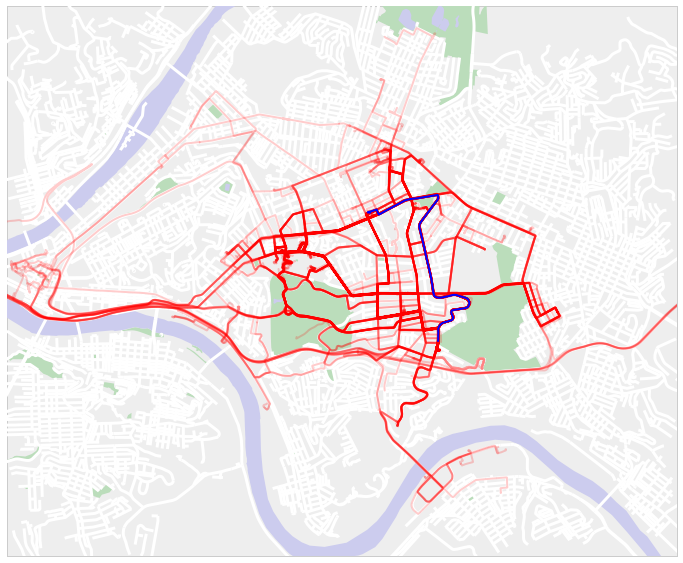

In [11]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')

for (idx,trip) in enumerate(training):
    ax.plot(trip.x, trip.y, lw=2, alpha=0.2, c='red', zorder=99)
    
ax.plot(test.x, test.y, lw=2, alpha=1, c='blue', zorder=100)

In [12]:
test.head()

,Latitude,Longitude,Elevation,Bearing,PlanarDistance,Speed,Acceleration,Power,TotalEnergyUsed,PeriodMS,Time,ElapsedSeconds,Heading,Gradient,x,y
0,40.450752,-79.929198,247.734948,2.98,13.28,13.275005,0.000000,3342.2758,0.0000,1000,1267506595000,0,2.981878,0.001656,8315.788601,7858.642763
1,40.450771,-79.929353,247.758603,2.96,10.00,11.021376,-2.253629,-16710.7009,0.9284,1000,1267506596000,1,2.951334,0.001656,8298.534080,7861.411421
2,40.450788,-79.929469,247.780730,2.96,10.00,9.175370,-1.846006,1862.2865,-3.7135,1000,1267506597000,2,2.962280,0.002012,8285.621019,7863.888641
3,40.450804,-79.929585,247.801039,2.90,6.74,6.543060,-2.632310,-11461.9095,-3.1961,1000,1267506598000,3,2.894059,0.001850,8272.707958,7866.220143
4,40.450819,-79.929663,247.819220,2.70,2.74,3.169773,-3.373287,-5999.9652,-6.3800,1000,1267506599000,4,2.716125,0.002329,8264.025038,7868.405927


In [75]:
features = ['Latitude', 'Longitude', 'Bearing', 'Speed', 'Acceleration', 'Power', 'TotalEnergyUsed']
feature_weights =  [1,1,1e3,0,1e-2,0,1e-2]
ep = ensemblepredictor.EnsemblePredictor(training, features=features, feature_weights=feature_weights)

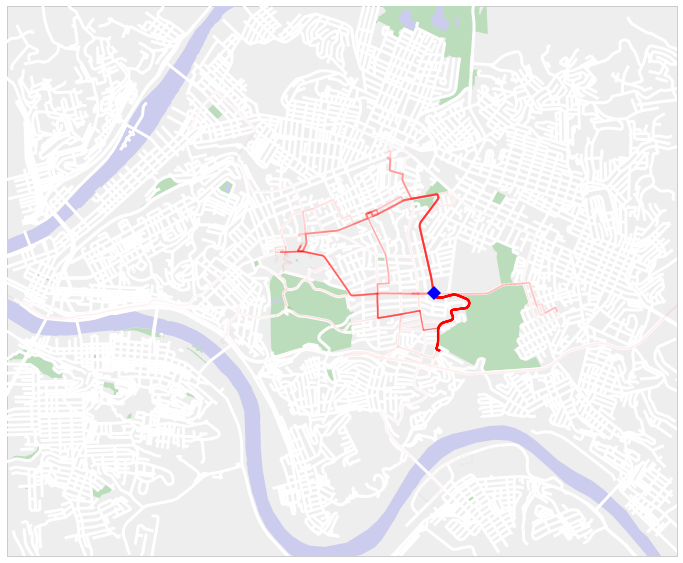

In [76]:
index = 400
results = [(1.0/r[0],r[1]) for r in ep.predict(test.iloc[index])]
best_weight = max(results)[0]
results = [(w/best_weight, i) for (w,i) in results]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')

for (r, trip) in zip(results, training):
    idx = r[1]
    ax.plot(trip.x.iloc[idx:], trip.y.iloc[idx:], lw=2, alpha=r[0], c='red', zorder=99)

ax.plot(test.x.iloc[index], test.y.iloc[index], 'bD', markersize=10, zorder=101)


In [77]:
for index in range(0,len(test),10):
    results = [(1.0/r[0],r[1]) for r in ep.predict(test.iloc[index])]
    best_weight = max(results)[0]
    results = [(w/best_weight, i) for (w,i) in results]

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    mymap.draw_map(ax, map_fill='#eeeeee')

    for (r, trip) in zip(results, training):
        idx = r[1]
        ax.plot(trip.x.iloc[idx:], trip.y.iloc[idx:], lw=4, alpha=r[0], c='red', zorder=99)

    ax.plot(test.x.iloc[index], test.y.iloc[index], 'bD', markersize=10, zorder=101)
    plt.savefig('video/frame'+str(index)+'.jpg')
    plt.clf()